In [56]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Set plot style for better visuals
sns.set(style='whitegrid')
# Load the CSV file into a DataFrame
data = pd.read_csv('./instagram_data.csv')

# Show the first few rows of the dataset
data.head()
data.shape


(3785, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   likes                3785 non-null   int64 
 1   no_of_comments       3785 non-null   int64 
 2   t                    3785 non-null   int64 
 3   follower_count_at_t  3785 non-null   int64 
 4   image_path           3785 non-null   object
dtypes: int64(4), object(1)
memory usage: 148.0+ KB
likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64


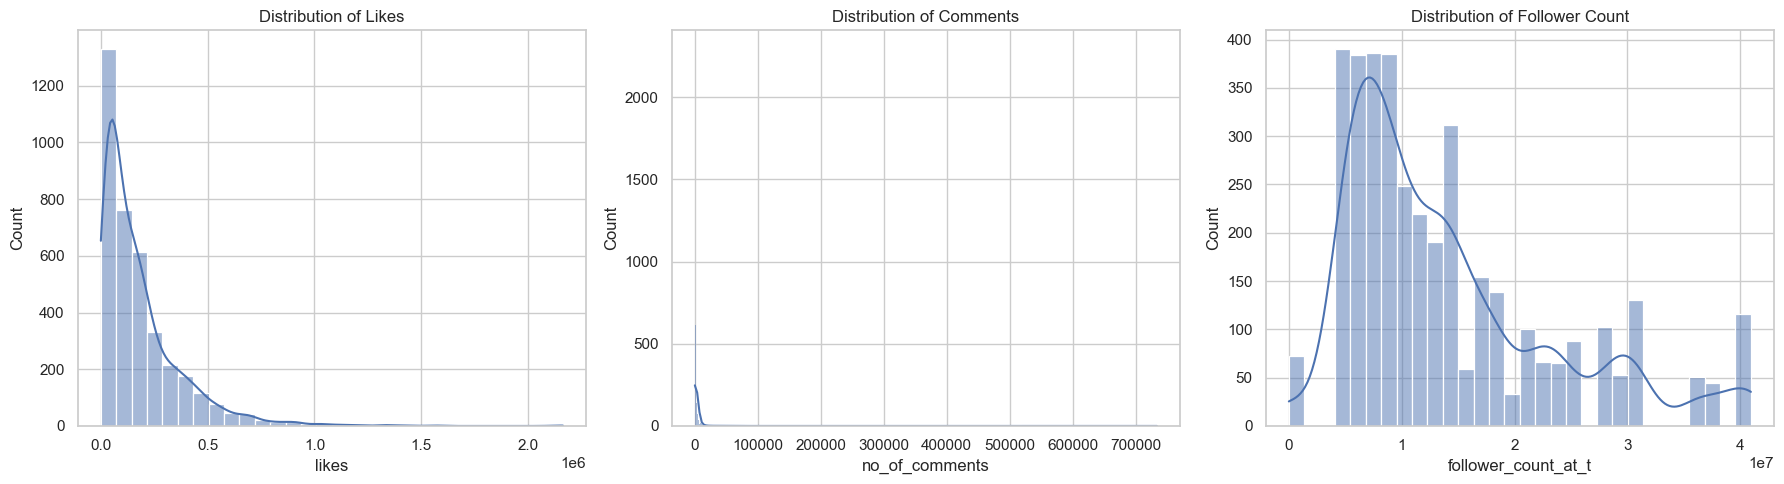

In [57]:
# Get basic information about the data (types, non-null counts, etc.)
data.info()

# Check for missing values
print(data.isnull().sum())

# Show descriptive statistics for numeric columns
data.describe()

# Visualize the distribution of likes, comments, and follower count
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot distribution of 'likes'
sns.histplot(data['likes'], ax=axes[0], bins=30, kde=True)
axes[0].set_title('Distribution of Likes')

# Plot distribution of 'no_of_comments'
sns.histplot(data['no_of_comments'], ax=axes[1], bins=1000, kde=True)
axes[1].set_title('Distribution of Comments')

# Plot distribution of 'follower_count_at_t'
sns.histplot(data['follower_count_at_t'], ax=axes[2], bins=30, kde=True)
axes[2].set_title('Distribution of Follower Count')

plt.tight_layout()
plt.show()


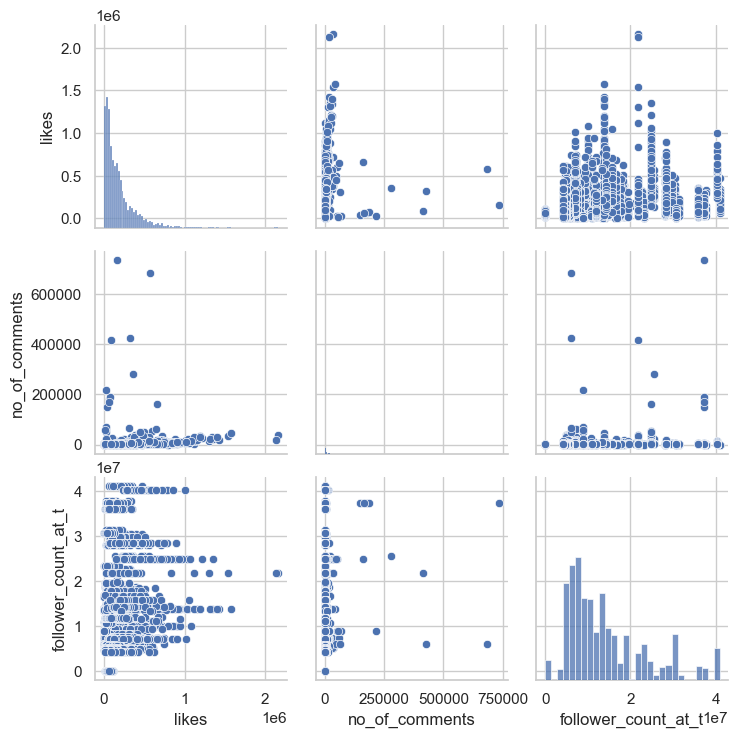

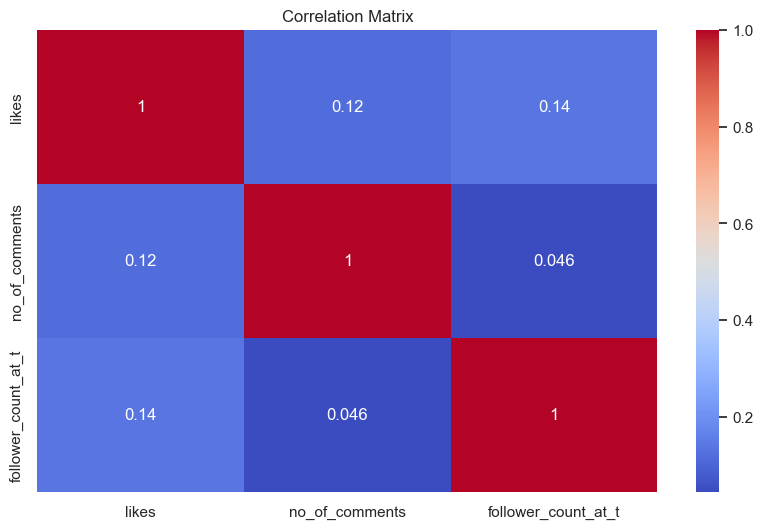

In [58]:
# Plot relationships between variables using pairplot
sns.pairplot(data[['likes', 'no_of_comments', 'follower_count_at_t']])
plt.show()

# Check correlations between numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(data[['likes', 'no_of_comments', 'follower_count_at_t']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


(62, 5, 105, 5)


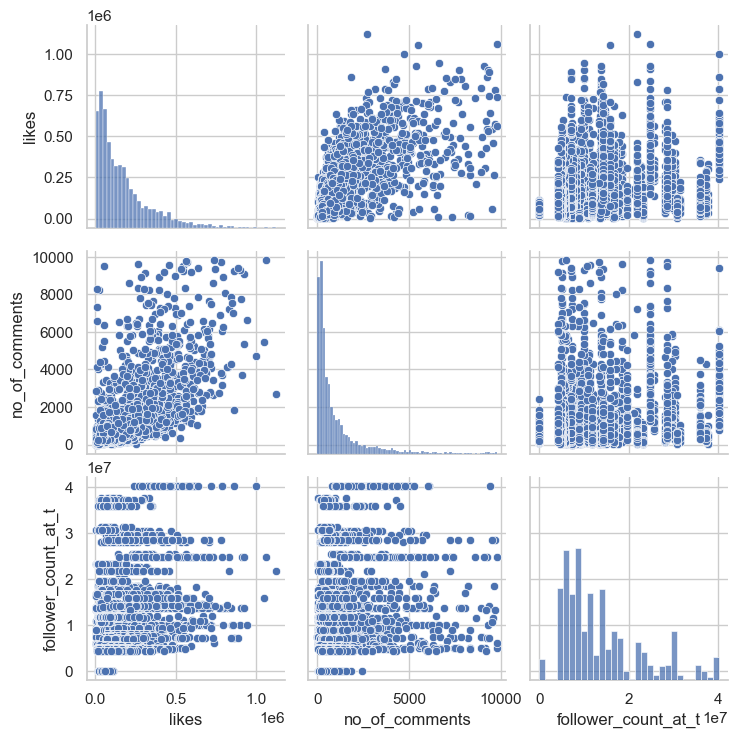

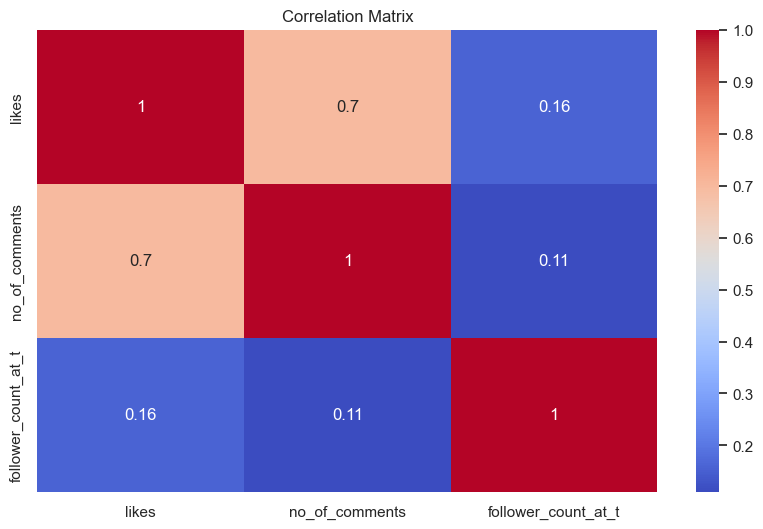

In [59]:
print(data[data.no_of_comments == 0].shape, data[data.no_of_comments > 10000].shape)

# Comments over 10000 are few and far in between, while comments at 0 could be due to post locking, which we do not want to predict for
data = data[data.no_of_comments < 10000]
data = data[data.no_of_comments > 0]
# Plot relationships between variables using pairplot
sns.pairplot(data[['likes', 'no_of_comments', 'follower_count_at_t']])
plt.show()

# Check correlations between numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(data[['likes', 'no_of_comments', 'follower_count_at_t']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [60]:
#Add new features
data['engagement_rate'] = (data.no_of_comments + data.likes) / data.follower_count_at_t
data['post_time'] = pd.to_datetime(data['t'], unit='s')
data['hour_of_day'] = data['post_time'].dt.hour  # Extract hour of the day (0-23)
data['day_of_week'] = data['post_time'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
data['month'] = data['post_time'].dt.month  # Extract the month (1-12)
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Binary weekend feature

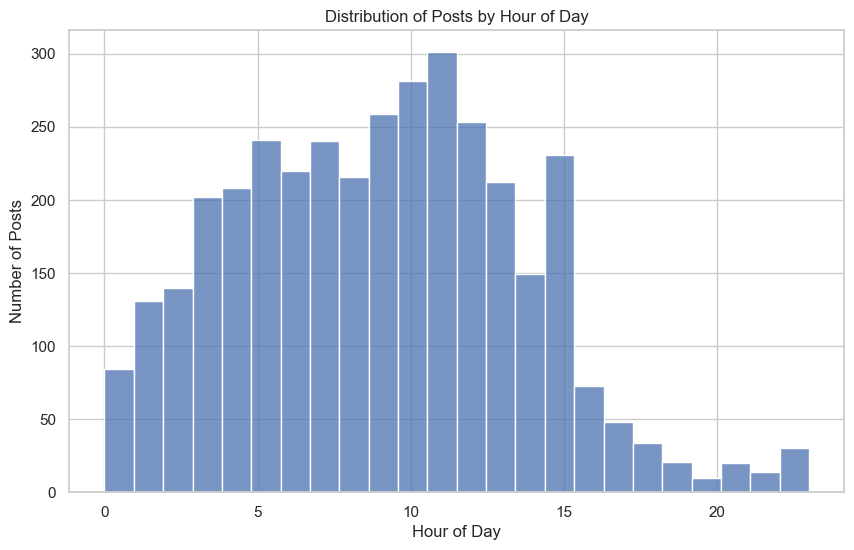

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the hour of the day
plt.figure(figsize=(10,6))
sns.histplot(data['hour_of_day'], bins=24, kde=False)
plt.title('Distribution of Posts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.show()


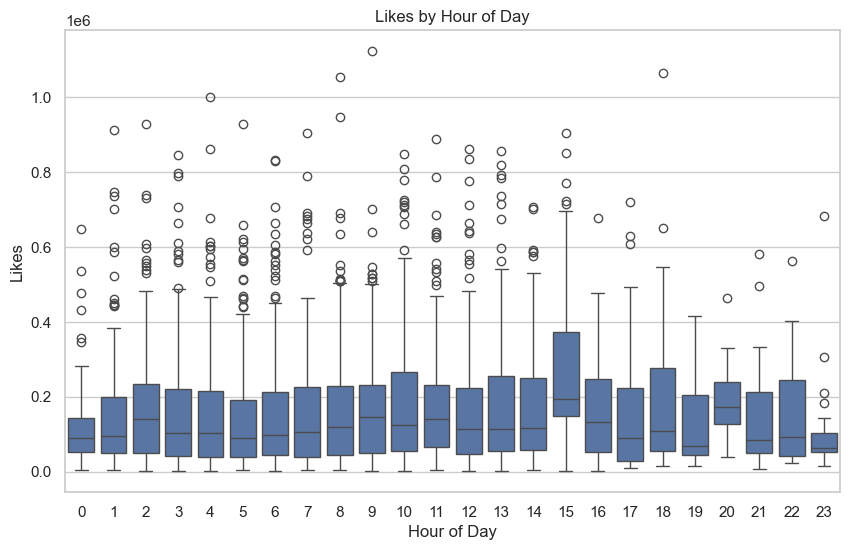

In [65]:
plt.figure(figsize=(10,6))
sns.boxplot(x='hour_of_day', y='likes', data=data)
plt.title('Likes by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Likes')
plt.show()

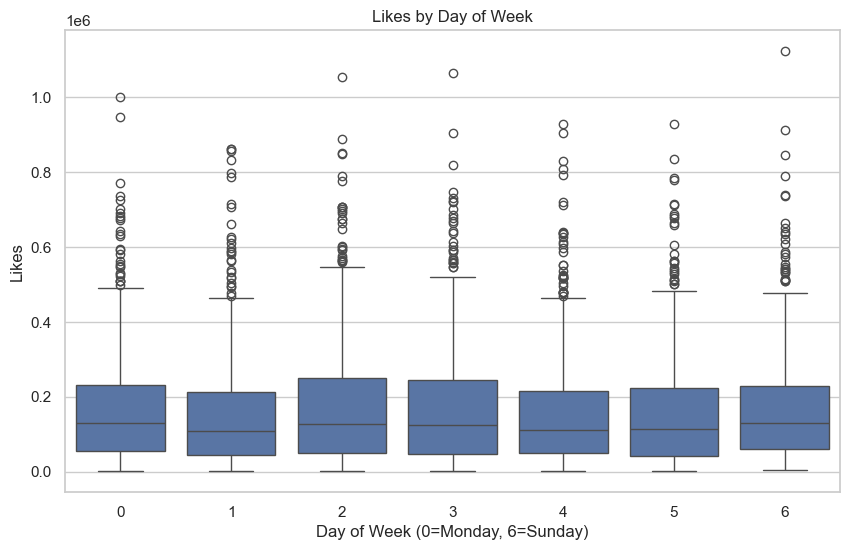

In [72]:
plt.figure(figsize=(10,6))
sns.boxplot(x='day_of_week', y='likes', data=data)
plt.title('Likes by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Likes')
plt.show()


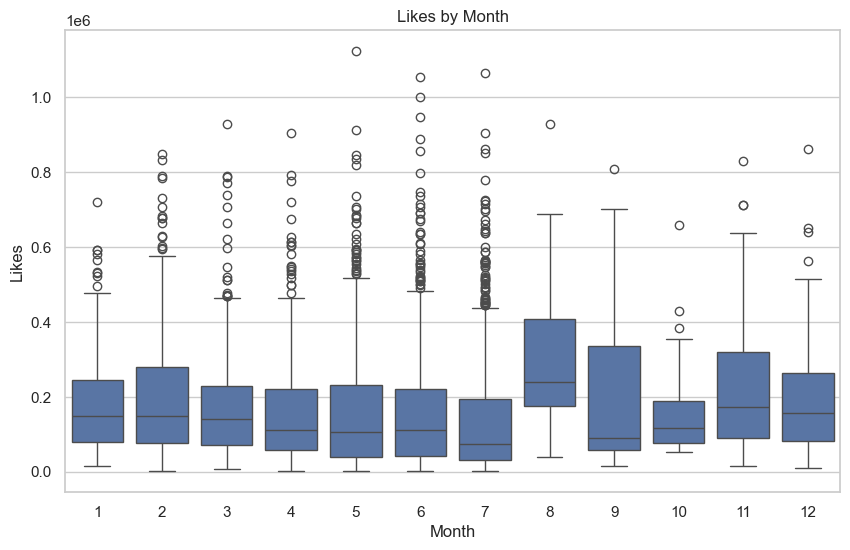

In [74]:
plt.figure(figsize=(10,6))
sns.boxplot(x='month', y='likes', data=data)
plt.title('Likes by Month')
plt.xlabel('Month')
plt.ylabel('Likes')
plt.show()


In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_weekend', y='likes', data=df)
plt.title('Likes on Weekends vs Weekdays')
plt.xlabel('Is Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('Likes')
plt.show()
